 All required import statement

In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
# import tensorflow as tf
import os
import gc

from sklearn import set_config
from sklearn.base import clone
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import lightgbm as lgb
import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

sns.set_theme(style='white', palette='viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)
set_config(transform_output='pandas')
pd.options.mode.chained_assignment = None
seed = 42
tss = TimeSeriesSplit(9)
kf = KFold(n_splits=10)
os.environ['PYTHONHASHSEED'] = '42'

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 Prepare the function to read the data

In [2]:
dtypes = {
    'stock_id': np.uint8,
    'date_id': np.uint16,
    'seconds_in_bucket': np.uint16,
    'imbalance_buy_sell_flag': np.int8,
    'time_id': np.uint16,
}


def add_derivatives(train_raw, derivatives_targets):
    # Load data from the save path
    train_raw.sort_values(by=['stock_id', 'time_id'], inplace=True)
    for target in derivatives_targets:
        train_raw[f'first_derivative_{target}'] = train_raw['reference_price'] - \
            train_raw['reference_price'].shift(1)
        train_raw[f'first_derivative_{target}'] = train_raw.apply(
            lambda x: 0 if x['seconds_in_bucket'] == 0 else x[f'first_derivative_{target}'], axis=1)
        train_raw[f'sec_derivative_{target}'] = train_raw[f'first_derivative_{target}'] - \
            train_raw[f'first_derivative_{target}'].shift(1)
        train_raw[f'sec_derivative_{target}'] = train_raw.apply(
            lambda x: 0 if x['seconds_in_bucket'] <= 10 else x[f'sec_derivative_{target}'], axis=1)

    # print(train_raw.head())
    train_raw.sort_values(by=['time_id', 'stock_id'], inplace=True)
    # print(train_raw.head())
    return train_raw


def imbalance_calculator(x):

    x_copy = x.copy()

    x_copy['imb_s1'] = x.eval('(bid_size - ask_size) / (bid_size + ask_size)')
    x_copy['imb_s2'] = x.eval(
        '(imbalance_size - matched_size) / (matched_size + imbalance_size)')

    prices = ['reference_price', 'far_price',
              'near_price', 'ask_price', 'bid_price', 'wap']

    for i, a in enumerate(prices):
        for j, b in enumerate(prices):
            if i > j:
                x_copy[f'{a}_{b}_imb'] = x.eval(f'({a} - {b}) / ({a} + {b})')

    for i, a in enumerate(prices):
        for j, b in enumerate(prices):
            for k, c in enumerate(prices):
                if i > j and j > k:
                    max_ = x[[a, b, c]].max(axis=1)
                    min_ = x[[a, b, c]].min(axis=1)
                    mid_ = x[[a, b, c]].sum(axis=1)-min_-max_

                    x_copy[f'{a}_{b}_{c}_imb2'] = (max_-mid_)/(mid_-min_)

    return x_copy


def read_data(data_path: str):
    """Read the data from the train and test csv files, split them into the x (features) and y(target)

    Args:
        data_path (str): absolute save path for the train and test data set 

    Returns:
        X (dataframe): Independent features for training
        y (dataframe): dependent features for training  
        X_test (dataframe): Independent features for testing
    """
    # Load data from the save path
    train = pd.read_csv(f'{data_path}/train.csv',
                        dtype=dtypes)
    train = add_derivatives(train, ['reference_price'])
    train.drop(['row_id', 'time_id'], axis=1, inplace=True)
    train = imbalance_calculator(train)
    test = pd.read_csv(f'{data_path}/test.csv',
                       dtype=dtypes).drop(['row_id', 'time_id'], axis=1)

    # Check the data set
    train.info()
    print(train.head())
    print(train.tail())
    gc.collect()

    # split data into X and y
    X = train[~train.target.isna()]
    y = X.pop('target')

    # Test data dont have target column
    X_test = test[~train.target.isna()]

    X.info()
    print(X.head())
    return X, y, X_test

 add_derivatives("D:/OneDrive/NEU/CS6140/optiver-trading-at-the-close")

 This section will prepare the cross_validation function
 cv = time series split of 10

In [3]:
def cross_validation(estimator, save_path, X, y, X_test, cv=kf, label=''):
    """cross validation function

    Args:
        estimator (model): chosen model 
        save_path (str) : target directory to save the model
        X (dataframe): Independent features for training
        y (dataframe): dependent features for training  
        X_test (dataframe): Independent features for testing
        cv (split, optional): split for the cross validation. Defaults to tss.
        label (str, optional): special label. Defaults to ''.

    Returns:
        _type_: _description_
    """
    # Build the save path if not exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # initiate prediction arrays and score lists
    val_predictions = np.zeros((len(X)))
    # train_predictions = np.zeros((len(sample)))
    train_scores, val_scores = [], []
    best_model = None
    best_model_train_score = 0
    best_val_score = 0
    best_fold = 0

    # training model, predicting prognosis probability, and evaluating metrics
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):

        model = clone(estimator)

        # define train set
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]

        # define validation set
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]

        # train model
        model.fit(X_train, y_train)

        # Save the model
        joblib.dump(model, f'./{save_path}/{label}_{fold}.model')

        # make predictions
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)

        val_predictions[val_idx] += val_preds

        # evaluate model for a fold
        train_score = mean_absolute_error(y_train, train_preds)
        val_score = mean_absolute_error(y_val, val_preds)

        # Update best model
        if best_val_score == 0 or val_score < best_val_score:
            best_val_score = val_score
            best_model_train_score = train_score
            best_model = model
            best_fold = fold

        # append model score for a fold to list
        train_scores.append(train_score)
        val_scores.append(val_score)

    # This line print the average
    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')
    for fold in range(len(val_scores)):
        print(
            f'fold:{fold}, Val Score: {val_scores[fold]}, Train Score: {train_scores[fold]}')
    # Print best model score
    print(
        f'Best validation score: {best_val_score}, associated train score: {best_model_train_score}')
    joblib.dump(best_model, f'./{save_path}/best_model.model')

    return val_scores, val_predictions

 This will set the Optuna objective function
 Set the objective function for Optuna study and running trials

In [4]:
def objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "max_bin": trial.suggest_int("max_bin", 63, 256),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15)
    }
    cv = kf
    cv_scores = np.empty(10)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        # define train set
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]

        # define validation set
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]

        model = LGBMRegressor(random_state=seed, objective='mse',
                              device_type='gpu', early_stopping_rounds=100, **param_grid)
        # train model
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)],  callbacks=[
                  LightGBMPruningCallback(trial, 'l2')])
        val_preds = model.predict(X_val)

        # evaluate model for a fold
        val_score = mean_absolute_error(y_val, val_preds)
        cv_scores[fold] = val_score
    return np.min(cv_scores)

 Call the required function and run the model

In [5]:
models = [
    ('LightGBM', LGBMRegressor(random_state=seed, objective='mse', device_type='gpu'))
]
X, y, X_test = read_data(
    "D:/OneDrive/NEU/CS6140/optiver-trading-at-the-close")

<class 'pandas.core.frame.DataFrame'>
Index: 5237980 entries, 0 to 5237979
Data columns (total 54 columns):
 #   Column                                     Dtype  
---  ------                                     -----  
 0   stock_id                                   uint8  
 1   date_id                                    uint16 
 2   seconds_in_bucket                          uint16 
 3   imbalance_size                             float64
 4   imbalance_buy_sell_flag                    int8   
 5   reference_price                            float64
 6   matched_size                               float64
 7   far_price                                  float64
 8   near_price                                 float64
 9   bid_price                                  float64
 10  bid_size                                   float64
 11  ask_price                                  float64
 12  ask_size                                   float64
 13  wap                                        floa

<ipython-input-2-f7e7208e6d08>:89: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test = test[~train.target.isna()]


<class 'pandas.core.frame.DataFrame'>
Index: 5237892 entries, 0 to 5237979
Data columns (total 53 columns):
 #   Column                                     Dtype  
---  ------                                     -----  
 0   stock_id                                   uint8  
 1   date_id                                    uint16 
 2   seconds_in_bucket                          uint16 
 3   imbalance_size                             float64
 4   imbalance_buy_sell_flag                    int8   
 5   reference_price                            float64
 6   matched_size                               float64
 7   far_price                                  float64
 8   near_price                                 float64
 9   bid_price                                  float64
 10  bid_size                                   float64
 11  ask_price                                  float64
 12  ask_size                                   float64
 13  wap                                        floa

 Run the optuna function

In [6]:
study = optuna.create_study(direction='minimize', study_name='LGBM Regressor')
def func(trial): return objective(trial, X, y)
study.optimize(func, n_trials=20)

[I 2023-12-06 07:12:54,196] A new study created in memory with name: LGBM Regressor


[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=1.8537626218563257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8537626218563257
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=1.8537626218563257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8537626218563257
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3424
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 53
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[123]	valid_0's l2: 107.525


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=1.8537626218563257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8537626218563257
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=1.8537626218563257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8537626218563257
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=1.8537626218563257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8537626218563257
[LightGBM] [Info] This 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[50]	valid_0's l2: 98.6703
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=1.8537626218563257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8537626218563257
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=1.8537626218563257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8537626218563257
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Cu

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[100]	valid_0's l2: 97.0311


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=1.8537626218563257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8537626218563257
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=1.8537626218563257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8537626218563257
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=1.8537626218563257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8537626218563257
[LightGBM] [Info] This 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already repo

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[120]	valid_0's l2: 84.5681


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=1.8537626218563257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8537626218563257
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=1.8537626218563257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8537626218563257
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=1.8537626218563257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8537626218563257
[LightGBM] [Info] This 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[181]	valid_0's l2: 88.7769


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=1.8537626218563257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8537626218563257
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=1.8537626218563257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8537626218563257
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=1.8537626218563257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8537626218563257
[LightGBM] [Info] This 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[125]	valid_0's l2: 79.689


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=1.8537626218563257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8537626218563257
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=1.8537626218563257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8537626218563257
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=1.8537626218563257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8537626218563257
[LightGBM] [Info] This 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[83]	valid_0's l2: 77.4608


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=1.8537626218563257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8537626218563257


[I 2023-12-06 07:20:02,240] Trial 0 finished with value: 5.184739942077818 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28846406510222494, 'num_leaves': 200, 'max_depth': 7, 'min_data_in_leaf': 6600, 'max_bin': 66, 'min_gain_to_split': 1.8537626218563257}. Best is trial 0 with value: 5.184739942077818.


[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=4.133698816916528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.133698816916528
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=4.133698816916528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.133698816916528
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3577
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 53
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already re

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 301 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 302 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 303 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 304 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 305 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 306 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 307 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 308 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 309 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 310 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 311 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 312 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 313 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 314 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 315 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 316 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 317 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 318 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 319 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 320 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 321 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 322 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 323 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 324 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 325 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 326 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 327 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 328 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 329 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 330 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 331 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 332 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 333 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 334 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 335 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 336 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 337 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 338 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 339 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 340 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 341 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 342 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 343 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 344 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 345 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 346 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 347 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 348 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 349 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 350 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 351 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 352 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 353 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 354 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 355 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 356 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 357 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 358 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 359 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 360 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 361 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 362 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 363 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 364 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 365 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 366 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 367 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 368 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 369 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 370 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 371 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 372 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 373 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 374 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 375 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 376 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 377 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 378 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 379 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 380 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 381 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 382 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 383 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 384 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 385 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 386 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 387 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 388 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 389 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 390 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 391 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 392 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 393 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 394 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 395 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 396 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 397 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 398 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 399 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 400 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 401 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 402 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 403 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 404 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 405 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 406 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 407 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 408 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 409 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 410 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 411 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 412 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 413 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 414 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 415 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 416 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 417 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 418 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 419 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 420 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 421 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 422 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 423 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 424 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 425 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 426 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 427 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 428 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 429 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 430 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 431 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 432 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 433 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 434 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 435 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 436 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 437 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 438 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 439 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 440 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 441 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 442 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 443 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 444 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 445 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 446 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 447 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 448 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 449 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 450 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 451 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 452 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 453 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 454 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 455 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 456 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 457 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 458 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 459 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 460 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 461 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 462 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 463 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 464 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 465 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 466 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 467 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 468 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 470 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 471 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 472 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 473 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 474 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 475 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 476 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 477 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 478 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 479 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 480 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 481 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 482 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 483 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 484 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 485 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 486 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 487 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 488 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 489 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 490 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 491 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 492 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 493 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 494 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 495 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 496 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 497 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 498 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 499 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 500 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 501 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 502 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 503 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 504 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 505 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 506 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 507 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 508 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 509 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 510 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 511 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 512 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 513 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 514 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 515 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 516 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 517 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 518 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 519 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 520 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 521 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 522 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 523 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 524 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 525 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 526 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 527 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 528 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 529 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 530 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 531 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 532 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 533 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 534 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 535 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 536 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 537 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 538 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 539 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 540 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 541 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 542 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 543 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 544 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 545 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 546 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 547 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 548 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 549 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 550 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 551 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 552 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 553 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 554 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 555 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 556 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 557 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 558 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 559 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 560 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 562 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 563 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 564 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 565 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 566 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 567 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 568 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 569 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 570 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 571 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 572 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 573 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 574 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 575 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 576 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 577 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 578 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 579 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 580 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 581 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 582 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 583 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 584 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 585 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 586 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 587 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 588 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 589 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 590 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 591 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 592 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 593 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 594 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 595 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 596 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 597 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 598 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 599 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 600 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 601 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 602 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 603 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 604 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 605 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 606 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 607 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 608 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 609 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 610 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 611 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 612 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 613 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 614 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 615 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 616 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 617 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 618 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 619 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 620 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 621 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 622 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 623 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 624 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 625 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 626 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 627 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 628 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 629 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 630 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 631 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 632 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 633 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 634 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 635 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 636 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 637 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 638 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 639 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 640 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 641 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 642 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 643 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 644 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 645 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 646 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 647 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 648 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 649 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 650 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 651 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 652 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 653 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 654 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 655 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 656 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 657 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 658 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 659 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 660 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 661 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 662 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 663 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 664 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 665 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 666 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 667 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 668 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 669 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 670 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 671 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 672 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 673 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 674 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 675 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 676 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 677 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 678 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 679 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 680 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 681 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 682 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 683 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 684 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 685 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 686 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 687 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 688 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 689 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 690 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 691 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 692 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 693 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 694 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 695 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 696 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 697 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 698 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 699 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 700 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 701 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 702 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 703 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 704 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 705 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 706 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 707 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 708 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 709 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 710 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 711 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 712 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 713 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 714 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 715 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 716 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 717 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 718 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 719 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 720 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 721 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 722 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 723 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 724 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 725 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 726 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 727 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 728 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 729 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 730 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 731 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 732 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 733 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 734 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 735 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 736 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 737 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 738 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 739 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 740 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 741 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 742 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 743 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 744 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 745 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 746 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 747 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 748 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 749 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 750 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 751 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 752 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 753 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 754 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 755 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 756 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 757 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 758 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 759 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 760 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 761 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 762 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 763 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 764 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 765 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 766 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 767 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 768 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 769 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 770 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 771 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 772 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 773 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 774 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 775 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 776 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 301 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 302 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 303 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 304 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 305 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 306 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 307 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 308 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 309 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 310 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 311 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 312 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 313 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 314 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 315 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 316 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 317 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 318 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 319 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 320 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 321 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 322 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 323 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 324 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 325 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 326 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 327 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 328 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 329 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 330 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 331 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 332 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 333 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 334 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 335 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 337 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 338 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 339 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 340 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 341 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 342 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 343 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 344 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 345 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 346 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 347 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 348 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 349 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 350 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 351 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 352 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 353 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 354 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 355 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 356 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 357 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 358 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 359 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 360 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 361 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 362 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 363 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 364 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 365 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 366 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 367 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 368 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 369 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 370 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 371 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 372 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 373 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 374 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 375 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 376 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 377 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 378 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 379 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 380 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 381 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 382 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 383 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 384 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 385 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 386 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 387 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 388 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 389 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 390 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 391 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 392 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 393 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 394 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 395 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 396 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 397 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 398 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 399 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 400 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 401 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 402 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 403 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 404 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 405 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 406 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 407 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 408 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 409 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 410 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 411 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 412 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 413 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 414 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 415 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 416 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 417 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 418 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 419 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 420 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 421 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 422 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 423 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 424 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 425 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 426 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 427 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 428 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 429 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 430 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 431 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 432 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 433 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 434 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 435 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 437 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 438 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 439 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 440 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 441 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 442 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 443 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 444 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 445 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 446 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 447 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 448 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 449 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 450 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 451 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 452 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 453 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 454 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 455 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 456 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 457 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 458 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 459 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 460 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 461 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 462 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 463 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 464 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 465 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 466 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 467 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 468 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 469 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 470 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 471 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 472 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 473 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 474 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 475 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 476 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 477 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 478 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 479 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 480 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 481 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 482 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 483 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 484 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 485 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 486 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 487 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 488 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 489 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 490 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 491 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 492 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 493 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 494 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 495 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 496 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 497 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 498 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 499 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 500 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 501 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 502 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 503 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 504 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 505 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 506 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 507 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 508 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 509 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 510 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 511 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 512 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 513 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 514 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 515 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 516 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 517 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 518 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 519 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 520 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 521 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 522 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 523 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 524 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 525 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 526 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 527 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 528 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 529 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 530 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 531 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 532 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 533 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 534 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 535 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 536 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 537 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 538 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 539 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 540 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 541 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 542 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 543 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 544 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 545 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 546 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 547 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 548 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 549 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 550 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 551 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 552 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 553 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 554 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 555 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 556 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 557 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 558 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 559 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 560 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 561 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 562 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 563 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 564 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 565 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 566 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 567 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 568 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 569 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 570 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 571 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 572 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 573 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 574 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 575 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 576 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 577 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 578 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 579 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 580 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 581 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 582 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 583 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 584 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 585 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 586 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 587 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 588 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 589 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 590 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 591 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 592 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 593 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 594 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 595 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 596 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 597 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 598 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 599 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 600 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 601 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 602 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 603 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 604 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 605 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 606 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 607 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 608 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 609 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 610 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 611 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 612 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 613 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 614 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 615 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 616 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 617 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 618 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 619 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 620 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 621 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 622 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 623 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 624 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 625 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 626 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 627 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 628 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 629 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 630 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 631 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 632 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 633 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 634 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 635 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 636 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 637 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 638 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 639 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 640 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 641 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 642 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 643 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 644 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 645 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 646 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 647 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 648 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 649 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 650 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 651 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 652 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 653 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 654 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 655 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 656 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 657 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 658 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 659 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 660 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 661 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 662 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 663 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 664 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 665 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 666 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 667 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 668 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 669 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 670 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 671 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 672 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 673 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 674 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 675 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 676 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 677 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 678 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 679 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 680 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 681 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 682 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 683 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 684 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 685 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 686 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 687 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 688 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 689 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 690 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 691 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 692 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 693 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 694 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 695 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 696 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 697 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 698 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 699 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 700 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 701 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 702 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 703 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 704 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 705 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 706 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 707 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 708 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 709 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 710 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 711 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 712 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 713 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 714 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 715 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 716 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 717 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 718 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 719 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 720 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 721 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 722 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 723 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 724 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 725 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 726 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 727 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 728 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 729 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 730 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 731 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 732 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 733 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 734 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 735 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 736 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 737 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 738 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 739 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 740 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 741 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 742 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 743 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 744 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 745 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 746 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 747 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 748 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 749 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 750 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 751 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 752 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 753 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 754 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 755 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 756 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 757 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 758 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 759 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 760 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 761 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 762 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 763 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 764 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 765 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 766 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 767 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 768 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 769 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 770 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 771 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 773 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 774 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 775 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 776 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 777 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 778 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 779 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 780 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 781 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 782 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 783 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 784 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 785 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 786 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 787 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 788 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 789 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 790 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 791 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 792 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 793 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 794 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 795 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 796 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 797 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 798 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 799 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 800 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 801 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 802 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 803 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 804 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 805 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 806 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 807 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 808 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 809 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 810 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 811 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 812 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 813 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 814 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 815 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 816 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 817 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 818 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 819 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 820 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 821 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 822 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 823 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 824 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 825 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 826 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 827 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 828 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 829 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 830 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 831 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 832 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 833 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 834 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 835 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 836 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 837 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 838 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 839 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 840 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 841 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 842 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 843 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 844 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 845 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 846 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 847 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 848 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 849 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 850 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 851 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 852 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 853 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 854 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 855 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 856 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 857 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 858 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 859 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 860 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 861 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 862 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 863 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 864 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 865 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 866 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 867 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 868 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 869 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 870 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already re

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 301 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 302 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 303 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 304 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 305 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 306 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 307 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 308 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 309 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 310 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 311 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 312 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 313 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 314 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 315 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 316 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 317 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 318 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 319 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 320 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 321 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 322 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 323 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 324 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 325 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 326 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 327 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 328 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 329 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 330 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 331 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 332 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 333 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 334 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 335 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 336 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 337 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 338 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 339 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 340 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 341 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 342 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 343 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 344 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 345 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 346 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 347 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 348 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 349 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 350 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 351 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 352 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 353 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 354 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 355 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 356 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 357 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 358 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 359 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 360 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 361 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 362 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 363 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 364 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 365 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 366 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 367 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 368 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 369 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 370 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 371 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 372 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 373 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 374 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 375 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 376 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 377 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 378 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 379 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 380 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 381 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 382 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 383 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 384 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 385 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 386 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 387 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 388 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 389 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 390 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 391 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 392 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 393 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 394 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 395 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 396 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 397 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 398 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 399 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 400 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 401 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 402 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 403 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 404 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 405 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 406 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 407 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 408 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 409 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 410 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 411 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 412 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 413 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 414 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 415 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 416 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 417 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 418 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 419 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 420 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 421 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 422 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 423 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 424 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 425 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 426 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 427 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 428 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 429 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 430 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 431 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 432 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 433 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 434 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 435 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 436 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 437 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 438 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 439 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 440 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 441 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 442 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 443 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 444 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 445 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 446 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 447 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 448 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 449 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 450 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 451 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 452 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 453 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 454 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 455 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 456 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 457 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 458 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 459 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 460 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 461 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 462 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 463 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 464 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 465 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 466 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 467 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 468 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 469 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 470 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 471 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 472 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 473 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 474 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 475 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 476 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 477 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 478 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 479 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 480 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 481 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 482 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 483 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 484 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 485 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 486 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 487 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 488 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 489 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 490 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 491 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 492 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 493 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 494 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 495 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 497 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 498 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 499 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 500 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 501 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 502 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 503 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 504 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 505 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 506 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 507 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 508 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 509 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 510 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 511 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 512 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 513 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 514 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 515 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 516 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 517 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 518 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 519 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 520 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 521 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 522 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 523 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 524 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 525 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 526 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 527 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 528 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 529 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 530 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 531 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 532 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 533 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 534 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 535 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 536 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 537 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 538 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 539 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 540 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 541 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 542 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 543 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 544 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 545 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 546 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 547 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 548 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 549 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 550 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 551 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 552 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 553 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 554 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 555 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 556 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 557 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 558 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 559 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 560 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 561 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 562 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 563 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 564 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 565 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 566 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 567 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 568 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 569 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 570 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 571 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 572 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 573 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 574 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 575 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 576 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 577 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 578 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 579 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 580 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 581 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 582 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 583 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 584 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 585 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 586 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 587 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 588 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 589 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 590 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 591 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 592 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 593 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 594 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 595 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 596 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 597 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 598 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 599 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 600 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 601 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 602 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 603 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 604 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 605 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 606 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 607 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 608 is already reported.
  warnings.warn(


Early stopping, best iteration is:
[509]	valid_0's l2: 98.5738
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=4.133698816916528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.133698816916528
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=4.133698816916528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.133698816916528
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=4.133698816916528, min_split_gain=0.0 will be ignored. Current value: mi

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already re

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already re

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 301 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 302 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 303 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 304 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 305 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 306 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 307 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 308 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 309 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 310 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 311 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 312 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 313 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 314 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 315 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 316 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 317 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 318 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 319 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 320 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 321 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 322 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 323 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 324 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 325 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 326 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 327 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 328 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 329 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 330 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 331 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 332 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 333 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 334 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 335 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 336 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 337 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 338 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 339 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 340 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 341 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 342 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 343 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 344 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 345 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 346 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 347 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 348 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 349 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 350 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 351 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 352 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 353 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 354 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 355 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 356 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 357 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 358 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 359 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 360 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 361 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 362 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 363 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 364 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 365 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 366 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 367 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 368 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 369 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 370 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 371 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 372 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 373 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 374 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 375 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 376 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 377 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 378 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 379 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 380 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 381 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 382 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 383 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 384 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 385 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 386 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 387 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 388 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 389 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 390 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 391 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 392 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 393 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 394 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 395 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 396 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 397 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 398 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 399 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 400 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 401 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 402 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 403 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 404 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 405 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 406 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 407 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 408 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 409 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 410 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 411 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 412 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 413 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 414 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 415 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 416 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 417 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 418 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 419 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 420 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 421 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 422 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 423 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 424 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 425 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 426 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 427 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 428 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 429 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 430 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 431 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 432 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 433 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 434 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 435 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 436 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 437 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 438 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 439 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 440 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 441 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 442 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 443 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 444 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 445 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 446 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 447 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 448 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 449 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 450 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 451 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 452 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 453 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 454 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 455 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 456 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 457 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 458 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 459 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 460 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 461 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 462 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 463 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 464 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 465 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 466 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 467 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 468 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 469 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 470 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 471 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 472 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 473 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 474 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 475 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 476 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 477 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 478 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 479 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 480 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 481 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 482 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 483 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 484 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 485 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 486 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 487 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 488 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 489 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 490 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 491 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 492 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 493 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 494 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 495 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 496 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 497 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 498 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 499 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 500 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 501 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 502 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 503 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 504 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 505 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 506 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 507 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 508 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 509 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 510 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 511 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 512 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 513 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 514 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 515 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 516 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 517 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 518 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 519 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 520 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 521 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 522 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 523 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 524 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 525 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 526 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 527 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 528 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 529 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 530 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 531 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 532 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 533 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 534 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 535 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 536 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 537 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 538 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 539 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 540 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 541 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 542 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 543 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 544 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 545 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 546 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 547 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 548 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 549 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 550 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 551 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 552 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 553 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 554 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 555 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 556 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 557 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 558 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 559 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 560 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 561 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 562 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 563 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 564 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 565 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 566 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 567 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 568 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 569 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 570 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 571 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 572 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 573 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 574 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 575 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 576 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 577 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 578 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 579 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 580 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 581 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 582 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 583 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 584 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 585 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 586 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 587 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 588 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 589 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 590 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 591 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 592 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 593 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 594 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 595 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 596 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 597 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 598 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 599 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 600 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 601 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 602 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 603 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 604 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 605 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 606 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 607 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 608 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 609 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 610 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 611 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 612 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 613 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 614 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 615 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 616 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 617 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 618 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 619 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 620 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 621 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 622 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 623 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 624 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 625 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 626 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 627 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 628 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 629 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 630 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 631 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 632 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 633 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 634 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 635 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 636 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 637 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 638 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 639 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 640 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 641 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 642 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 643 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 644 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 645 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 646 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 647 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 648 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 649 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 650 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 651 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 652 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 653 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 654 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 655 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 656 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 657 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 658 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 659 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 660 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 661 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 662 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 663 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 664 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 665 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 666 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 667 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 668 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 669 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 670 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 671 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 672 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 673 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 674 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 675 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 676 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 677 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 678 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 679 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 680 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 681 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 682 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 683 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 684 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 685 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 686 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 687 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 688 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 689 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 690 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 691 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 692 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 693 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 694 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 695 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 696 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 697 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 698 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 699 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 700 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 701 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 702 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 703 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 704 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 705 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 706 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 707 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 708 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 709 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 710 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 711 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 712 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 713 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 714 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 715 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 716 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 717 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 718 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 719 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 720 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 721 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 722 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 723 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 724 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 725 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 726 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 727 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 728 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 729 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 730 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 731 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 732 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 733 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 734 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 735 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 736 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 737 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 738 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 739 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 740 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 741 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 742 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 743 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 744 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 745 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 746 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 747 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 748 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 749 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 750 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 751 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 752 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 753 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 754 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 755 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 756 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 757 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 758 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 759 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 760 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 761 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 762 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 763 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 764 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 765 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 766 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 767 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 768 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 769 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 770 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 771 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 772 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 773 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 774 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 775 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 776 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 777 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 778 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 779 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 780 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 781 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 782 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 783 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 784 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 785 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 786 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 787 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 788 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 789 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 790 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 791 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 792 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 793 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 794 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 795 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 796 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 797 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 798 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 799 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 800 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 801 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 802 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 803 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 804 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 805 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 806 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 807 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 808 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 809 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 810 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 811 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 812 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 813 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 814 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 815 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 816 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 817 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 818 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 819 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 820 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 821 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 822 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 823 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 824 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 825 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 826 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 827 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 828 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 829 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 830 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 831 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 832 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 833 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 834 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 835 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 836 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 837 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 838 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 839 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 840 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 841 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 842 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 843 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 844 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 845 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 846 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 847 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 848 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 849 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 850 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 851 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 852 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 853 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 854 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 855 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 856 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 857 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 858 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 859 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 860 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 861 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 862 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 863 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 864 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 865 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 866 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 867 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 868 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 869 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 870 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 871 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 872 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 873 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 874 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 875 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 876 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 877 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 878 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 879 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 880 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 881 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 882 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 884 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 885 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 886 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 887 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 888 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 889 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 890 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[794]	valid_0's l2: 96.9049


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 891 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 892 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 893 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=4.133698816916528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.133698816916528
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=4.133698816916528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.133698816916528
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=4.133698816916528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.133698816916528
[LightGBM] [Info] This is the

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already re

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already re

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 301 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 302 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 303 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 304 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 305 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 306 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 307 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 308 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 309 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 310 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 311 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 312 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 313 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 314 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 315 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 316 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 317 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 318 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 319 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 320 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 321 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 322 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 323 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 324 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 325 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 326 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 327 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 328 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 329 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 330 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 331 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 332 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 333 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 334 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 335 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 336 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 337 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 338 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 339 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 340 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 341 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 342 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 343 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 344 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 345 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 346 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 347 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 348 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 349 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 350 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 351 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 352 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 353 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 354 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 355 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 356 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 357 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 358 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 359 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 360 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 361 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 362 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 363 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 364 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 365 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 366 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 367 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 368 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 369 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 370 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 371 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 372 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 373 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 374 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 375 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 376 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 377 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 378 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 379 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 380 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 381 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 382 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 383 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 384 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 385 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 386 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 387 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 388 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 389 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 390 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 391 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 392 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 393 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 394 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 395 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 396 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 397 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 398 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 399 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 400 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 401 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 402 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 403 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 404 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 405 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 406 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 407 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 408 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 409 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 410 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 411 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 412 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 413 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 414 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 415 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 416 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 417 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 418 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 419 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 420 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 421 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 422 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 423 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 424 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 425 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 426 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 427 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 428 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 429 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 430 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 431 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 432 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 433 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 434 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 435 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 436 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 437 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 438 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 439 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 440 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 441 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 442 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 443 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 444 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 445 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 446 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 447 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 448 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 449 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 450 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 451 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 452 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 453 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 454 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 455 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 456 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 457 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 458 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 459 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 460 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 461 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 462 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 463 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 464 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 465 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 466 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 467 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 468 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 469 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 470 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 471 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 472 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 473 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 474 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 475 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 476 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 477 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 478 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 479 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 480 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 481 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 482 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 483 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 484 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 485 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 486 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 487 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 488 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 489 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 490 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 491 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 492 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 493 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 494 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 495 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 496 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 497 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 498 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 499 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 500 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 501 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 502 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 503 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 504 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 506 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 507 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 508 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 509 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 510 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 511 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 512 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 513 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 514 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 515 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 516 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 517 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 518 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 519 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 520 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 521 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 522 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 523 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 524 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 525 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 526 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 527 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 528 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 529 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 530 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 531 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 532 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 533 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 534 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 535 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 536 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 537 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 538 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 539 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 540 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 541 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 542 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 543 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 544 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 545 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 546 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 547 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 548 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 549 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 550 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 551 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 552 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 553 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 554 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 555 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 556 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 557 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 558 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 559 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 560 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 561 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 562 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 563 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 564 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 565 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 566 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 567 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 568 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 569 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 570 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 571 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 572 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 573 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 574 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 575 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 576 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 577 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 578 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 579 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 580 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 581 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 582 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 583 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 584 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 585 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 586 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 587 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 588 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 589 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 590 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 591 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 592 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 593 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 594 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 595 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 596 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 597 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 598 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 599 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 600 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 601 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 602 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 603 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 604 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 605 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 606 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 607 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 608 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 609 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 610 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 611 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 612 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 613 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 614 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 615 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 616 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 617 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 618 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 619 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 620 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 621 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 622 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 623 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 624 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 625 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 626 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 627 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 628 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 629 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 630 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 631 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 632 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 633 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 634 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 635 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 636 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 637 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 638 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 639 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 640 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 641 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 642 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 643 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 644 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 645 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 646 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 647 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 648 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 649 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 650 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 651 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 652 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 653 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 654 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 655 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 656 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 657 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 658 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 659 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 660 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 661 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 662 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 663 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 664 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 665 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 666 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 667 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 668 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 669 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 670 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 671 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 672 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 673 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 674 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 675 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 676 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 677 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 678 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 679 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 680 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 681 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 682 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 683 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 684 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 685 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 686 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 687 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 688 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 689 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 690 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 691 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 692 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 693 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 694 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 695 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 696 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 697 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 698 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 699 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 700 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 701 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 702 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 703 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 704 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 705 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 706 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 707 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 708 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 709 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 710 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 711 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 712 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 713 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 714 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 715 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 716 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 717 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 718 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 719 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 720 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 721 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 722 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 723 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 724 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 725 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 726 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 727 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 728 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 729 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 730 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 731 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 732 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 733 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 734 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 735 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 736 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 737 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 738 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 739 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 740 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 741 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 742 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 743 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 744 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 745 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 746 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 747 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 748 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 749 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 750 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 751 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 752 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 753 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 754 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 755 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 756 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 757 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 758 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 759 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 760 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 761 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 762 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 763 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 764 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 765 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 766 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 767 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 768 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 769 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 770 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 771 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 772 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 773 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 774 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 775 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 776 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 777 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 778 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 779 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 780 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 781 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 782 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 783 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 784 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 785 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 786 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 787 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 788 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 789 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 790 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 791 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 792 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 793 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 794 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 795 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 796 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 797 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 798 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 799 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 800 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 801 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 802 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 803 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 804 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 805 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 806 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 807 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 808 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 809 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 810 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 811 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 812 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 813 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 814 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 815 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 816 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 817 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 818 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 819 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 820 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 821 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 822 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 823 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 824 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 825 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 826 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 827 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 828 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 829 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 830 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 831 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 832 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 833 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 834 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 835 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 836 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 837 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 838 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 839 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 840 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 841 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 842 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 843 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 844 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 845 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 846 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 847 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 848 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 849 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 850 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 851 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 852 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 853 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 854 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 855 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 856 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 857 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 858 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 859 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 860 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 861 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 862 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 863 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 865 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 866 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 867 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 868 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 869 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 870 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 871 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 872 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 873 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 874 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 875 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 876 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 877 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 878 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 879 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 880 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 881 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 882 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 883 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 884 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 885 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 886 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 887 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 888 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 889 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 890 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 891 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 892 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 893 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 894 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 895 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 896 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 897 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 898 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 899 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 900 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 901 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 902 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 903 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 904 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 905 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 906 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 907 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 908 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 909 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 910 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 911 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 912 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 913 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 914 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 915 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 916 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 917 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 918 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 919 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 920 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 921 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 922 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 923 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 924 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 925 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 926 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 927 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already re

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already re

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 301 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 302 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 303 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 304 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 305 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 306 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 307 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 308 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 309 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 310 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 311 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 312 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 313 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 314 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 315 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 316 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 317 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 318 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 319 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 320 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 321 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 322 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 323 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 324 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 325 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 326 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 327 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 328 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 329 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 330 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 331 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 332 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 333 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 334 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 335 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 336 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 337 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 338 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 339 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 340 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 341 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 342 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 343 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 344 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 345 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 346 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 347 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 348 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 349 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 350 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 351 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 352 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 353 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 354 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 355 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 356 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 357 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 358 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 359 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 360 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 361 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 362 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 363 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 364 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 365 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 366 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 367 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 368 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 369 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 370 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 371 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 372 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 373 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 374 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 375 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 376 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 377 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 378 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 379 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 380 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 381 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 382 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 383 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 384 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 385 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 386 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 387 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 388 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 389 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 390 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 391 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 392 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 393 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 394 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 395 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 396 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 397 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 398 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 399 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 400 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 401 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 402 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 403 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 404 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 405 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 406 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 407 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 408 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 409 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 410 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 411 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 412 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 413 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 414 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 415 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 416 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 417 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 418 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 419 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 420 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 421 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 422 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 423 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 424 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 425 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 426 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 427 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 428 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 429 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 430 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 431 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 432 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 433 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 434 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 435 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 436 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 437 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 438 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 439 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 440 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 441 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 442 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 443 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 444 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 445 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 446 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 447 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 448 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 449 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 450 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 451 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 452 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 453 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 454 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 455 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 456 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 457 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 458 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 459 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 460 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 461 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 462 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 463 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 464 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 465 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 466 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 467 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 468 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 469 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 470 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 471 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 472 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 473 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 474 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 475 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 476 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 477 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 478 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 479 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 480 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 481 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 482 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 483 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 484 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 485 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 486 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 487 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 488 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 489 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 490 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 491 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 492 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 493 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 494 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 495 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 496 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 497 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 498 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 499 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 500 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 501 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 502 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 503 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 504 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 505 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 506 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 507 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 508 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 509 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 510 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 511 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 512 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 513 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 514 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 515 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 516 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 517 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 518 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 519 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 520 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 521 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 522 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 523 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 524 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 525 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 526 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 527 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 528 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 529 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 530 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 531 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 532 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 533 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 534 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 535 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 536 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 537 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 538 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 539 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 540 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 541 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 542 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 543 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 544 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 545 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 546 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 547 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 548 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 549 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 550 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 551 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 552 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 553 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 554 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 555 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 556 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 557 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 558 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 559 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 560 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 561 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 562 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 563 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 564 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 565 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 566 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 567 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 568 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 569 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 570 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 571 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 572 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 573 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 574 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 575 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 576 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 577 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 578 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 579 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 580 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 581 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 582 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 583 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 584 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 585 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 586 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 587 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 588 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 589 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 590 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 591 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 592 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 593 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 594 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 595 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 596 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 597 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 598 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 599 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 600 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 601 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 602 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 603 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 604 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 605 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 606 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 607 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 608 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 609 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 610 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 611 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 612 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 613 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 614 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 615 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 616 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 617 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 618 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 619 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 620 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 621 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 622 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 623 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 624 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 625 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 626 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 627 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 628 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 629 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 630 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 631 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 632 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 633 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 634 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 635 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 636 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 637 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 638 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 639 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 640 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 641 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 642 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 643 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 644 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 645 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 646 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 647 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 648 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 649 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 650 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 651 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 652 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 653 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 654 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 655 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 656 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 657 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 658 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 659 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 660 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 661 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 662 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 663 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 664 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 665 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 666 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 667 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 668 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 669 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 670 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 671 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 672 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 673 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 674 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 675 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 676 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 677 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 678 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 679 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 680 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 681 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 682 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 683 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 684 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 685 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 686 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 687 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 688 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 689 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 690 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 691 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 692 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 693 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 694 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 695 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 696 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 697 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 698 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 699 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 700 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 701 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 702 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 703 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 704 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 705 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 706 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 707 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 708 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 709 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 710 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 711 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 712 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 713 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 714 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 715 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 716 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 717 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 718 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 719 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 720 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 721 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 722 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 723 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 724 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 725 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 726 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 727 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 728 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 729 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 730 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 731 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 732 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 733 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 734 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 735 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 736 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 737 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 738 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 739 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 740 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 741 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 742 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 743 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 744 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 745 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 746 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 747 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 748 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 749 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 750 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 751 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 752 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 753 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 754 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 755 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 756 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 757 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 758 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 759 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 760 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[664]	valid_0's l2: 84.4656


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 761 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 762 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 763 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=4.133698816916528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.133698816916528
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=4.133698816916528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.133698816916528
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=4.133698816916528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.133698816916528
[LightGBM] [Info] This is the

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already re

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 301 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 302 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 303 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 304 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 305 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 306 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 307 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 308 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 309 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 310 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 312 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 313 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 314 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 315 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 316 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 317 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 318 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 319 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 320 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 321 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 322 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 323 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 324 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 325 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 326 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 327 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 328 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 329 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 330 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 331 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 332 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 333 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 334 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 335 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 336 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 337 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 338 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 339 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 340 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 341 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 342 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 343 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 344 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 345 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 346 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 347 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 348 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 349 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 350 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 351 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 352 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 353 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 354 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 355 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 356 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 357 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 358 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 359 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 360 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 361 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 362 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 363 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 364 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 365 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 366 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 367 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 368 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 369 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 370 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 371 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 372 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 373 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 374 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 375 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 376 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 377 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 378 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 379 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 380 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 381 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 382 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 383 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 384 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 385 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 386 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 387 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 388 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 389 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 390 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 391 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 392 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 393 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 394 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 395 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 396 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 397 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 398 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 399 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 400 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 401 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 402 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 403 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 404 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 405 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 406 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 407 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 408 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 409 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 410 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 411 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 412 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 413 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 414 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 415 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 416 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 417 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 418 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 419 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 420 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 421 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 422 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 423 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 424 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 425 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 426 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 427 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 428 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 429 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 430 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 431 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 432 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 433 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 434 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 435 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 436 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 437 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 438 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 439 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 440 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 441 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 442 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 443 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 444 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 445 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 447 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 448 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 449 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 450 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 451 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 452 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 453 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 454 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 455 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 456 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 457 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 458 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 459 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 460 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 461 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 462 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 463 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 464 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 465 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 466 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 467 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 468 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 469 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 470 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 471 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 472 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 473 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 474 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 475 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 476 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 477 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 478 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 479 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 480 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 481 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 482 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 483 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 484 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 485 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 486 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 487 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 488 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 489 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 490 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 491 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 492 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 493 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 494 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 495 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 496 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 497 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 498 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 499 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 500 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 501 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 502 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 503 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 504 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 505 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 506 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 507 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 508 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 509 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 510 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 511 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 512 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 513 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 514 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 515 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 516 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 517 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 518 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 519 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 520 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 521 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 522 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 523 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 524 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 525 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 526 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 527 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 528 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 529 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 530 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 531 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 532 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 533 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 534 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 535 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 536 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 537 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 538 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 539 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 540 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 541 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 542 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 543 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 544 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 545 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 546 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 547 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 548 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 549 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 550 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 551 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 552 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 553 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 554 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 555 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 556 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 557 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 558 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 559 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 560 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 561 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 562 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 563 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 564 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 565 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 566 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 567 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 568 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 569 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 570 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 571 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 572 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 573 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 574 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 575 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 576 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 577 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 578 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 579 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 580 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 581 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 582 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 583 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 584 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 585 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 586 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 587 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 588 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 589 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 590 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 591 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 592 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 593 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 594 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 595 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 596 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 597 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 598 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 599 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 600 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 602 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 603 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 604 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 605 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 606 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 607 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 608 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 609 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 610 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 611 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 612 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 613 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 614 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 615 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 616 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 617 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 618 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 619 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 620 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 621 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 622 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 623 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 624 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 625 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 626 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 627 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 628 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 629 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 630 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 631 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 632 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 633 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 634 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 635 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 636 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 637 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 638 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 639 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 640 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 641 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 642 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 643 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 644 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 645 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 646 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 647 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 648 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 649 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 650 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 651 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 652 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 653 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 654 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 655 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 656 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 657 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 658 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 659 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 660 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 661 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 662 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 663 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 664 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 665 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 666 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 667 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 668 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 669 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 670 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 671 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 672 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 673 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 674 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 675 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 676 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 677 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 678 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 679 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 680 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 681 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 682 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 683 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 684 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 685 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 686 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 687 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 688 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 689 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 690 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 691 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 692 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 693 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 694 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 695 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 696 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 697 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 698 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 699 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 700 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 701 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 702 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 703 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 704 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 705 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 706 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 707 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 708 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 709 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 710 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 711 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 712 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 713 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 714 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 715 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 716 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 717 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 718 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 719 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 720 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 721 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 722 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 723 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 724 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 725 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 726 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 727 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 728 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 729 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 730 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 731 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 732 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 733 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 734 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 735 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 736 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 737 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 738 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 739 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 740 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 741 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 742 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 743 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 744 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 745 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 746 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 747 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 748 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 749 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 750 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 751 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 752 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 753 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 754 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 755 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 756 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 757 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 758 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 759 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 760 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 761 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 762 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 763 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 764 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 765 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 766 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 767 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 768 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 769 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 770 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 771 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 772 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 773 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 774 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 775 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 776 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 777 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 778 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 779 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 780 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 781 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 782 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 783 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 784 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 785 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 786 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 787 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 788 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 789 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 790 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 791 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 792 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 793 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 794 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 795 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 796 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 797 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 798 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 799 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 800 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 801 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 802 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 803 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 804 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 805 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 806 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 807 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 808 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 809 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 810 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 811 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 812 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 813 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 814 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 815 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 816 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 817 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 818 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 819 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 820 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 821 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 822 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 823 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 824 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 825 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 826 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 827 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 828 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 829 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 830 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 831 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 832 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 833 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 834 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 835 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 836 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 837 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 838 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 839 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 840 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 841 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 842 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 843 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 844 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 845 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 846 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 847 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 848 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 849 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 850 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 851 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 852 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 853 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 854 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 855 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 856 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 857 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 858 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 859 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 860 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 861 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 862 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 863 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 864 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 865 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 866 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 867 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 868 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 869 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 870 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 871 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 872 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 873 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 874 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 875 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 876 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 877 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 878 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 879 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 880 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 881 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 882 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 883 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 884 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 885 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 886 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 887 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 888 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 889 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 890 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 891 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 892 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 893 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 894 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 895 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 896 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 897 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 898 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 899 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 900 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 901 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 902 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 903 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 904 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 905 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 906 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 907 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 908 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 909 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 910 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 911 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 912 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 913 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 914 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 915 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 916 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 917 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 918 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 919 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 920 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 921 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 922 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 923 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 924 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 925 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 926 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 927 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 928 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 929 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 930 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 931 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 932 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 933 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 934 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 935 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 936 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 937 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 938 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 939 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 940 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 941 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 942 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 943 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 944 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 945 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 946 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 947 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 948 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 949 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 950 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 951 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 952 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 953 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 954 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 955 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 956 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 957 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 958 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 959 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 960 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 961 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 962 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 963 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 964 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 965 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 966 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 967 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 968 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 969 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 970 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 971 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 972 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 973 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 974 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 975 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already re

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already re

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 301 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 302 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 303 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 304 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 305 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 306 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 307 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 308 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 309 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 310 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 311 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 312 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 313 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 314 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 315 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 316 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 317 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 318 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 319 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 320 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 321 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 322 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 323 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 324 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 325 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 326 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 327 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 328 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 329 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 330 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 331 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 332 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 333 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 334 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 335 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 336 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 337 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 338 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 339 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 340 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 341 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 342 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 343 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 344 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 345 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 346 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 347 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 348 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 349 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 350 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 351 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 352 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 353 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 354 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 355 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 356 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 357 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 358 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 359 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 360 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 361 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 362 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 363 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 364 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 365 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 366 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 367 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 368 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 369 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 370 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 371 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 372 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 373 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 374 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 375 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 376 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 377 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 378 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 379 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 380 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 381 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 382 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 383 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 384 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 385 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 386 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 387 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 388 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 389 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 390 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 391 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 392 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 393 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 394 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 395 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 396 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 397 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 398 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 399 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 400 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 401 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 402 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 403 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 404 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 405 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 406 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 407 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 408 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 409 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 410 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 411 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 412 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 413 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 414 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 415 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 416 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 417 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 418 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 419 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 420 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 421 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 422 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 423 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 424 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 425 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 426 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 427 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 428 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 429 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 430 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 431 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 432 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 433 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 434 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 435 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 436 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 437 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 438 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 439 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 440 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 441 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 442 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 443 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 444 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 445 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 446 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 447 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 448 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 449 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 450 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 451 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 452 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 453 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 454 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 455 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 456 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 457 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 458 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 459 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 460 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 461 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 462 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 463 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 464 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 465 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 466 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 467 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 468 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 469 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 470 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 471 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 472 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 473 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 474 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 475 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 476 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 477 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 478 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 479 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 480 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 481 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 482 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 483 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 484 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 485 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 486 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 487 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 488 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 489 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 490 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 491 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 492 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 493 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 494 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 495 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 496 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 497 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 498 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 499 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 500 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 501 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 502 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 503 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 504 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 505 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 506 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 507 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 508 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 509 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 510 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 511 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 512 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 513 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 514 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 515 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 516 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 517 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 518 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 519 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 520 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 521 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 522 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 523 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 524 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 525 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 526 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 527 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 528 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 529 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 530 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 531 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 532 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 533 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 534 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 535 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 536 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 537 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 538 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 539 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 540 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 541 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 542 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 543 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 544 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 545 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 546 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 547 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 548 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 549 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 550 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 551 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 552 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 553 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 554 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 555 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 556 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 557 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 558 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 559 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 560 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 561 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 562 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 563 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 564 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 565 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 566 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 567 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 568 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 569 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 570 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 571 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 572 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 573 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 574 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 575 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 576 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 577 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 578 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 579 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 580 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 581 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 582 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 583 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 584 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 585 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 586 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 587 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 588 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 589 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 590 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 591 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 592 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 593 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 594 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 595 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 596 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 597 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 598 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 599 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 600 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 601 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 602 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 603 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 604 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 605 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 606 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 607 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 608 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 609 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 610 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 611 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 612 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 613 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 614 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 615 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 616 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 617 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 618 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 619 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 620 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 621 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 622 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 623 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 624 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 625 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 626 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 627 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 628 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 629 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 630 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 631 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 632 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 633 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 634 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 635 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 636 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 637 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 638 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 639 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 640 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 641 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 642 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 643 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 644 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 645 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 646 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 647 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 648 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 649 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 650 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 651 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 652 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 653 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 654 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 655 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 656 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 657 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 658 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 659 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 660 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 661 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 662 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 663 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 664 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 665 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 666 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 667 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 668 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 669 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 670 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 671 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 672 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 673 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 674 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 675 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 676 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 677 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 678 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 679 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 680 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 681 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 682 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 683 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 684 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 685 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 686 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 687 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 688 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 689 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 690 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 691 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 692 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 693 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 695 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 696 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 697 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 698 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 699 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 700 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 701 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 702 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 703 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 704 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 705 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 706 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 707 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 708 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 709 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 710 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 711 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 712 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 713 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 714 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 715 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 716 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 717 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 718 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 719 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 720 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 721 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 722 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 723 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 724 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 725 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 726 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 727 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 728 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 729 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 730 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 731 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 732 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 733 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 734 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 735 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 736 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 737 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 738 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 739 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 740 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 741 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 742 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 743 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 744 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 745 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 746 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 747 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 748 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 749 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 750 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 751 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 752 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 753 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 754 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 755 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 756 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 757 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 758 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 759 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 760 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 761 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 762 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 763 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 764 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 765 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 766 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[667]	valid_0's l2: 79.6217
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=4.133698816916528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.133698816916528
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=4.133698816916528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.133698816916528
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Curre

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already re

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already re

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 301 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 302 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 303 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 304 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 305 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 306 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 307 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 308 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 309 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 310 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 311 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 312 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 313 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 314 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 315 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 316 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 317 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 318 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 319 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 320 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 321 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 322 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 323 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 324 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 325 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 326 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 327 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 328 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 329 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 330 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 331 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 332 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 333 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 334 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 335 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 336 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 337 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 338 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 339 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 340 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 341 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 342 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 343 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 344 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 345 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 346 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 347 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 348 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 349 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 350 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 351 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 352 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 353 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 354 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 355 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 356 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 357 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 358 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 359 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 360 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 361 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 362 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 363 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 364 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 365 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 366 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 367 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 368 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 369 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 370 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 371 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 372 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 373 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 374 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 375 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 376 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 377 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 378 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 379 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 380 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 381 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 382 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 383 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 384 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 385 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 386 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 387 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 388 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 389 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 390 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 391 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 392 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 393 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 394 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 395 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 396 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 397 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 398 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 399 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 400 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 401 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 402 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 403 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 404 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 405 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 406 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 407 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 408 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 409 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 410 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 411 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 412 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 413 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 414 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 415 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 416 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 417 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 418 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 419 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 420 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 421 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 422 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 423 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 424 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 425 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 426 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 427 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 428 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 429 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 430 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 431 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 432 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 433 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 434 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 435 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 436 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 437 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 438 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 439 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 440 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 441 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 442 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 443 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 444 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 445 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 446 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 447 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 448 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 449 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 450 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 451 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 452 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 453 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 454 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 455 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 456 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 457 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 458 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 459 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 460 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 461 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 462 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 463 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 464 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 465 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 467 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 468 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 469 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 470 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 471 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 472 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 473 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 474 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 475 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 476 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 477 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 478 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 479 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 480 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 481 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 482 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 483 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 484 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 485 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 486 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 487 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 488 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 489 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 490 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 491 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 492 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 493 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 494 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 495 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 496 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 497 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 498 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 499 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 500 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 501 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 502 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 503 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 504 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 505 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 506 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 507 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 508 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 509 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 510 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 511 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 512 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 513 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 514 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 515 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 516 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 517 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 518 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 519 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 520 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 521 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 522 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 523 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 524 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 525 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 526 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 527 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 528 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 529 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 530 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 531 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 532 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 533 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 534 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 535 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 536 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 537 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 538 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 539 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 540 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 541 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 542 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 543 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 544 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 545 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 546 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 547 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 548 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 549 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 550 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 551 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 552 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 553 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 554 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 555 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 556 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 557 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 558 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 559 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 560 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 561 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 562 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 563 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 564 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 565 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 566 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 567 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 568 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 569 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 570 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 571 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 572 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 573 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 574 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 575 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 576 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 577 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 578 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 579 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 580 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 581 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 582 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 583 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 584 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 585 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 586 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 587 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 588 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 589 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 590 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 591 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 592 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 593 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 594 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 595 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 596 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 597 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 598 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 599 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 600 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 601 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 602 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 603 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 604 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 605 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 606 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 607 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 608 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 609 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 610 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 611 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 612 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 613 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 614 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 615 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 616 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 617 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 618 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 619 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 620 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 621 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 622 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 623 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 624 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 625 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 626 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 627 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 628 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 629 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 630 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 631 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 632 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 633 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 634 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 635 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 636 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 637 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 638 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 639 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 640 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 641 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 642 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 643 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 644 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 645 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 646 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 647 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 648 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 649 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 650 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 651 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 652 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 653 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 654 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 655 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 656 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 657 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 658 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 659 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 660 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 661 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 662 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 663 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 664 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 665 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 666 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 667 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 668 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 669 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 670 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 671 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 672 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 673 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 674 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 675 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 676 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 677 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 678 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 679 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 680 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 681 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 682 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 683 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 684 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 685 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 686 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 687 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 688 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 689 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 690 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 691 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 692 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 693 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 694 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 695 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 696 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 697 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 698 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 699 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 700 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 701 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 702 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 703 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 704 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 705 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 706 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 707 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 708 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[610]	valid_0's l2: 77.4434


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 709 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=4.133698816916528, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.133698816916528


[I 2023-12-06 07:37:14,260] Trial 1 finished with value: 5.179726652757575 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09276507151247129, 'num_leaves': 900, 'max_depth': 5, 'min_data_in_leaf': 3100, 'max_bin': 69, 'min_gain_to_split': 4.133698816916528}. Best is trial 1 with value: 5.179726652757575.


[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] min_gain_to_split is set=3.228121792080685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.228121792080685
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] min_gain_to_split is set=3.228121792080685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.228121792080685
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 13050
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 53


[W 2023-12-06 07:37:33,199] Trial 2 failed with parameters: {'n_estimators': 10000, 'learning_rate': 0.2356480488437499, 'num_leaves': 2280, 'max_depth': 4, 'min_data_in_leaf': 8800, 'max_bin': 256, 'min_gain_to_split': 3.228121792080685} because of the following error: LightGBMError('bin size 257 cannot run on GPU').
Traceback (most recent call last):
  File "c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-6-97d02db1b3d9>", line 2, in func
    def func(trial): return objective(trial, X, y)
                            ^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-4-7f37ce317997>", line 25, in objective
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)],  callbacks=[
  File "c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py", line 1092, in fit
    super().fit(
  File "c:\U

LightGBMError: bin size 257 cannot run on GPU

 Check the optimization history and param_importances

	Best value (mse): 5.17973
	Best params:
		n_estimators: 10000
		learning_rate: 0.09276507151247129
		num_leaves: 900
		max_depth: 5
		min_data_in_leaf: 3100
		max_bin: 69
		min_gain_to_split: 4.133698816916528


<ipython-input-7-74515d8d1afc>:6: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)
<ipython-input-7-74515d8d1afc>:7: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

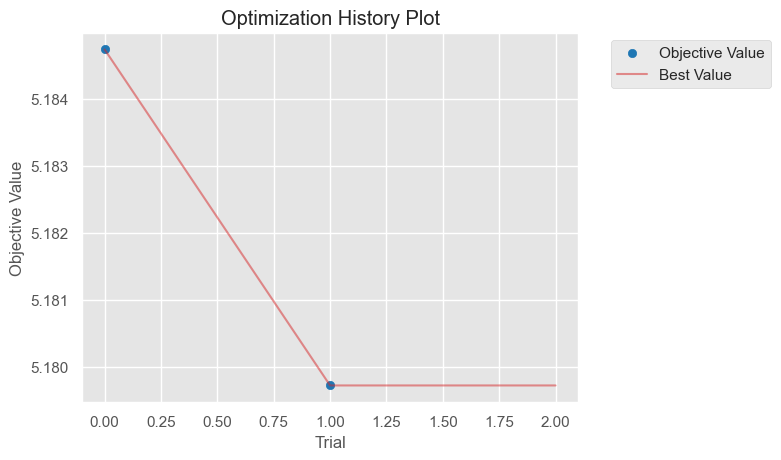

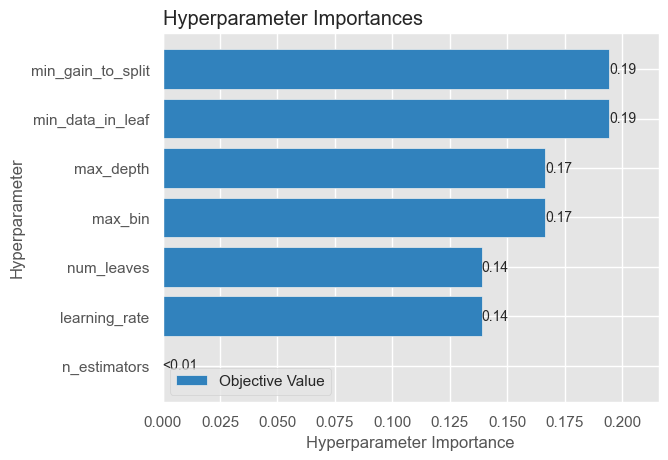

In [7]:
print(f"\tBest value (mse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")
plot_optimization_history(study)
plot_param_importances(study)